In [14]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set Constants

EPOCH = 200
STEPS_PER_EPOCH = 200
STEP = 2
PRED = 7
HIST = 365

In [15]:
# Establish Data
csv_path = "back_data.csv"
stock_a = pd.read_csv(csv_path)
TRAINING = int(np.floor(stock_a.shape[0] * .8))
# Filter unwanted features
features_list = ['open', 'high', 'low', 'close', 'volume']
features = stock_a[features_list]

features.index = stock_a['date']

stock_a.head()

,Unnamed: 0,symbol,open,high,low,close,volume,date
0,0,A,22.15,22.52,22.04,22.25,2386000.0,2003-10-01
1,1,A,22.10,22.18,21.84,21.99,2410700.0,2003-10-02
2,2,A,23.10,23.47,22.22,23.00,3951300.0,2003-10-03
3,3,A,23.00,23.23,22.81,23.03,945600.0,2003-10-06
4,4,A,22.90,23.56,22.70,23.43,1930500.0,2003-10-07


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022BB0D355E0>,
      dtype=object)

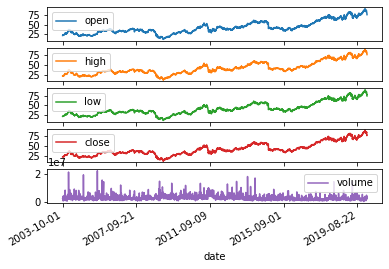

In [16]:
features.plot(subplots=True)

In [18]:
# Standardize the data
data = features.values
data = (data - data[:TRAINING].mean(axis=0)) / data[:TRAINING].std(axis=0)

In [19]:
# Pepare Data for training and validation based on desired history, prediction, and step length
x_train, y_train = split(data, data[:, 1], 0,
                                TRAINING, HIST, PRED, STEP)
x_val, y_val = split(data, data[:, 1],
                            TRAINING, None, 
                            HIST, PRED, STEP)                       

In [20]:
# Shuffle, Batch, and cache data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(10000).batch(256).repeat()

valid_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).cache().batch(256).repeat()

In [21]:
# Prevent keras from casting to float32
tf.keras.backend.set_floatx('float64')

# Initialize learning rate decay for models
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

In [45]:
# Initialize & Compile Simple RNN
simple_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(PRED, activation='elu')])
simple_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), 
              loss='mae',
              metrics=['accuracy'])

# Fit to validation data
simple_history = simple_model.fit(train_data,
                    epochs=EPOCH,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_data,
                    validation_steps=50)

NameError: name 'EPOCH' is not defined

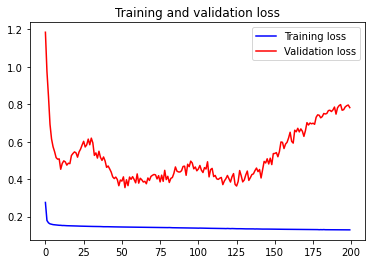

<RepeatDataset shapes: ((None, 183, 5), (None, 7)), types: (tf.float64, tf.float64)>

In [33]:
plot_train_history(simple_history, 'Training and validation loss')

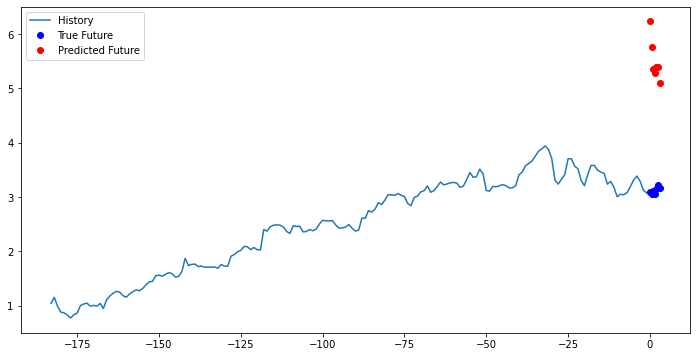

(256, 7)


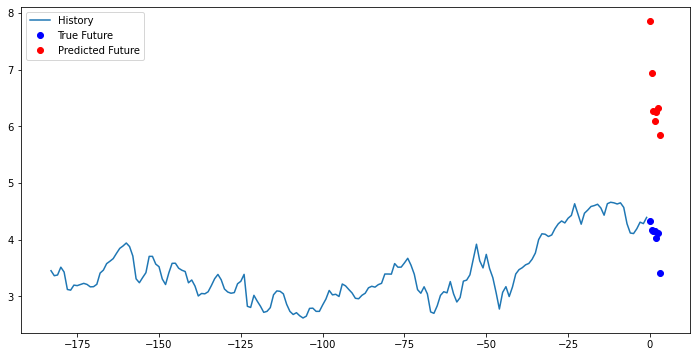

(199, 7)


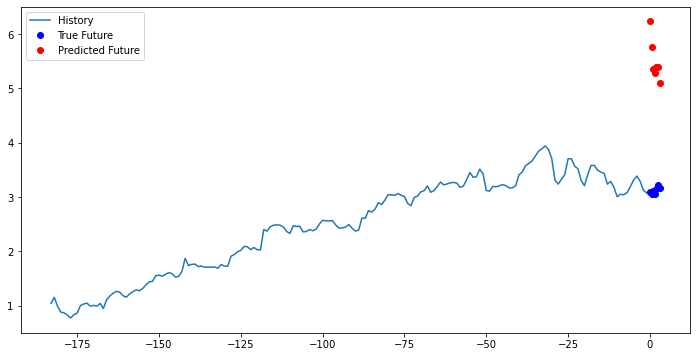

(256, 7)


In [35]:
for x, y in valid_data.take(3):
  plot_results(x[0], y[0], simple_model.predict(x)[0])

In [22]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dense(PRED, activation='elu')])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), loss='mae', metrics=['accuracy'])

history = lstm_model.fit(train_data,
                    epochs=EPOCH,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_data,
                    validation_steps=50)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.7668 - accuracy: 0.1641 - val_loss: 3.8471 - val_accuracy: 0.0989
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.7645 - accuracy: 0.1250 - val_loss: 3.8271 - val_accuracy: 0.0901
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.6748 - accuracy: 0.1445 - val_loss: 3.8138 - val_accuracy: 0.0879
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.7755 - accuracy: 0.1250 - val_loss: 3.7995 - val_accuracy: 0.0835
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.7748 - accuracy: 0.0859 - val_loss: 3.7832 - val_accuracy: 0.0813
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.7178 - accuracy: 0.0742 - val_loss: 3.7654 - val_accuracy: 0.0835
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.7640 - accuracy: 0.1055 - val_loss: 3.7468 - val_accuracy: 0.0835
Epoch 8/10
1/1 [=========================

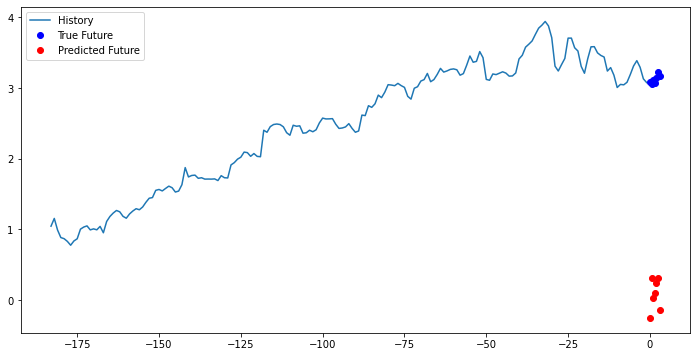

tf.Tensor(
[[[ 1.08354574  1.04554455  0.97660873  0.94505844  0.25860205]
  [ 1.04661308  1.15511308  1.07646791  1.03229767  0.60743496]
  [ 1.00660269  0.99127228  0.95910764  0.91529447  0.08251175]
  ...
  [ 3.24308072  3.29221153  3.2774877   3.27896436 -0.44845107]
  [ 3.13843817  3.12939474  3.00776497  3.04598431  0.86149024]
  [ 3.10253141  3.07614648  3.11585996  3.09524881 -1.08888792]]

 [[ 0.94710006  0.97079218  0.95293078  0.95224285  1.01600162]
  [ 1.03225037  0.98717626  1.01469934  1.00766542 -0.56193936]
  [ 0.93581508  0.8929678   0.9220465   0.90811006 -0.28130152]
  ...
  [ 3.10766095  3.21387515  3.12409577  3.13219719  0.41313136]
  [ 3.09022053  3.09662658  3.10916837  3.10448591 -0.61678069]
  [ 3.11792002  3.08638653  3.09218201  3.03982624 -0.43819455]]

 [[ 1.04661308  1.15511308  1.07646791  1.03229767  0.60743496]
  [ 1.00660269  0.99127228  0.95910764  0.91529447  0.08251175]
  [ 0.90708968  0.88477576  0.83145261  0.85576653 -0.10717859]
  ...
  [ 3.1

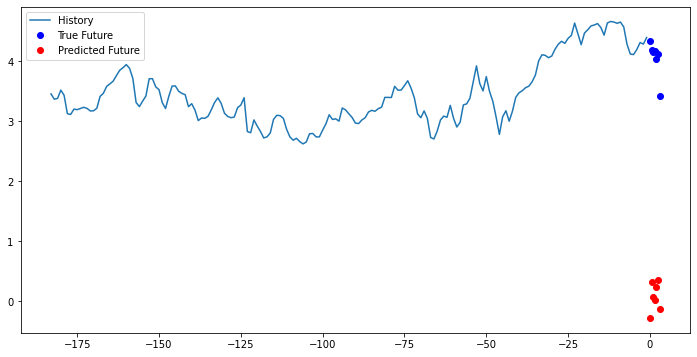

tf.Tensor(
[[[ 3.40414818  3.45195631  3.4236733   3.47294335  0.6771622 ]
  [ 3.38978547  3.36389188  3.35675736  3.34259768  0.01860054]
  [ 3.39799273  3.37617994  3.44632177  3.406231   -0.93935207]
  ...
  [ 4.24128858  4.3080245   4.29152161  4.349441   -0.76780388]
  [ 4.23821085  4.28242437  4.26735981  4.31865068 -1.23388047]
  [ 4.25975491  4.39199291  4.27402052  4.43668023 -0.82872906]]

 [[ 3.48314304  3.5113486   3.29498879  3.46781163  1.38686958]
  [ 3.35900825  3.36593989  3.40617221  3.41136272 -1.19273961]
  [ 3.43287358  3.52363666  3.4818387   3.53760301 -0.32116548]
  ...
  [ 4.34900885  4.34181666  4.28122685  4.24372758 -1.15509112]
  [ 4.35824201  4.40735298  4.41505874  4.43052216 -1.02081181]
  [ 4.35926792  4.32645659  4.15254234  4.16162007 -0.76429656]]

 [[ 3.38978547  3.36389188  3.35675736  3.34259768  0.01860054]
  [ 3.39799273  3.37617994  3.44632177  3.406231   -0.93935207]
  [ 3.52930887  3.51442062  3.3721995   3.34259768 -0.66149104]
  ...
  [ 4.2

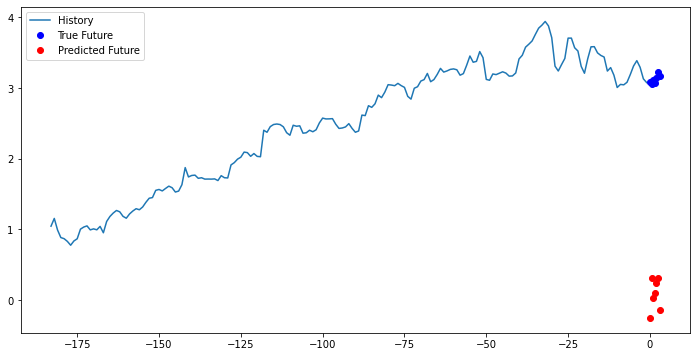

tf.Tensor(
[[[ 1.08354574  1.04554455  0.97660873  0.94505844  0.25860205]
  [ 1.04661308  1.15511308  1.07646791  1.03229767  0.60743496]
  [ 1.00660269  0.99127228  0.95910764  0.91529447  0.08251175]
  ...
  [ 3.24308072  3.29221153  3.2774877   3.27896436 -0.44845107]
  [ 3.13843817  3.12939474  3.00776497  3.04598431  0.86149024]
  [ 3.10253141  3.07614648  3.11585996  3.09524881 -1.08888792]]

 [[ 0.94710006  0.97079218  0.95293078  0.95224285  1.01600162]
  [ 1.03225037  0.98717626  1.01469934  1.00766542 -0.56193936]
  [ 0.93581508  0.8929678   0.9220465   0.90811006 -0.28130152]
  ...
  [ 3.10766095  3.21387515  3.12409577  3.13219719  0.41313136]
  [ 3.09022053  3.09662658  3.10916837  3.10448591 -0.61678069]
  [ 3.11792002  3.08638653  3.09218201  3.03982624 -0.43819455]]

 [[ 1.04661308  1.15511308  1.07646791  1.03229767  0.60743496]
  [ 1.00660269  0.99127228  0.95910764  0.91529447  0.08251175]
  [ 0.90708968  0.88477576  0.83145261  0.85576653 -0.10717859]
  ...
  [ 3.1

In [23]:
for x, y in valid_data.take(3):
  plot_results(x[0], y[0], lstm_model.predict(x)[0])
  print(x)

In [3]:
plot_compare(simple_history, history, 'Loss Comparison')

NameError: name 'simple_history' is not defined

In [13]:
##### HELPER FUNCTIONS #####

def split(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Split Data with data, step size, and indices
    """
    if end_index is None:
      end_index = len(dataset) - target_size

    data = []
    labs = []
    for i in range(start_index + history_size, end_index):
      data.append(dataset[range(i-history_size, i, step)])
      labs.append(target[i:i+target_size])

    return np.array(data), np.array(labs)

In [12]:
def plot_history(history, title):
    """
        Plot given history
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [11]:
def plot_compare(history_simple, history_LSTM, title):
    """
        Plot Model characteristics
    """

    simple_loss = history_simple.history['loss']
    simple_val_loss = history_simple.history['val_loss']

    LSTM_loss = history_LSTM.history['loss']
    LSTM_val_loss = history_LSTM.history['val_loss']

    epochs = range(len(simple_loss))

    plt.figure()

    plt.plot(epochs, simple_loss, 'b', label='Simple Training loss')
    plt.plot(epochs, simple_val_loss, 'r', label='Simple Validation loss')
    
    plt.plot(epochs, LSTM_loss, 'b', label='LSTM Training loss')
    plt.plot(epochs, LSTM_val_loss, 'r', label='LSTM Validation loss')
    
    plt.title(title)
    plt.legend()

    plt.show()

In [10]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = list(range(-plot_data[0].shape[0], 0 ))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [9]:
def plot_results(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out) / STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out) / STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [8]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [7]:
def create_time_steps(length):
  return list(range(-length, 0))